In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

num_cores=5
num_simulations = 1000 # number of monte carlo simulations
varscale=0.0

In [2]:
## each client actually generates data not from true beta, but from 
## true beta+some error; so if they run only sgd alone, they would never converge to the true beta.

np.set_printoptions(precision=4, suppress=True)



In [3]:
# --------------------------
# DFL Settings:
eta = 0.3
alpha = 0.75
K=10
#tau = 5
d=2


In [4]:
    np.random.seed(1907) # your favorite seed
    client_error = np.random.normal(loc=0.0, scale=varscale, size=(K,2)) ## errors for clients. client_error= np.zeros(K) if error for each client = 0.
    #client_error = np.zeros(K)

    beta_true = np.array([2.0, -3.0])
    sigma = np.array([random.randint(1, 10) for _ in range(K)])
    print(sigma)
    weights =  np.ones(K)/K
    beta_0 = np.sum(weights[:, np.newaxis] * (beta_true + client_error), axis=0)

    C = np.zeros((K, K))
    for i in range(K):
        C[i, i] = 1/3                    # self weight
        C[i, (i-1) % K] = 1/3             # left neighbor (with wrap-around)
        C[i, (i+1) % K] = 1/3             # right neighbor


    errors = client_error

    norms_sq = np.sum(errors**2, axis=1)

    sum_diag = np.sum(weights**2 * (sigma**2 + norms_sq))

    sum_outer = np.einsum('ki,kj->ij', errors, (weights**2)[:, None] * errors)

    V_K = sum_diag * np.eye(d) + sum_outer #calculate V_K
    print(V_K)
    A = np.eye(d) # hessian
    

[ 6  5  4  1  7  3  2 10  5  6]
[[10.4904  0.3793]
 [ 0.3793 10.3277]]


# Brownian motion

In [5]:
def simulate_Br(d, num_Simulations):
    """
    Simulate Z_t ~ N(0, (K V_K)^{-1}) and compute max ||sum_{s=1}^t Z_s||_2.
    Avoids explicit matrix inversion using Cholesky decomposition.
    
    Args:
        V_K: (d x d) positive definite matrix
        K: Scaling factor (K > 0)
        n: Number of time steps
        num_simulations: Number of independent runs
        
    Returns:
        max_norms: Array of maximum norms (num_simulations,)
    """
    
    
    Z = np.random.multivariate_normal(mean=np.zeros(d), cov= np.eye(d), size=num_simulations)

    # Compute cumulative sums 

    norms = np.linalg.norm(Z, ord=2,  axis=1)

    
    return norms


Br_results= simulate_Br(d, num_simulations)
x_grid = np.linspace(0, 50, 1000)  # Adjust the number of points as needed

prob_Br = np.array([np.mean(Br_results <= x) for x in x_grid])

(array([ 31.,  51.,  64.,  90., 102., 105., 112.,  90.,  84.,  71.,  45.,
         48.,  28.,  30.,  23.,  10.,   8.,   5.,   2.,   0.,   1.]),
 array([0.0712, 0.2483, 0.4254, 0.6024, 0.7795, 0.9566, 1.1337, 1.3108,
        1.4878, 1.6649, 1.842 , 2.0191, 2.1962, 2.3732, 2.5503, 2.7274,
        2.9045, 3.0816, 3.2586, 3.4357, 3.6128, 3.7899]),
 <BarContainer object of 21 artists>)

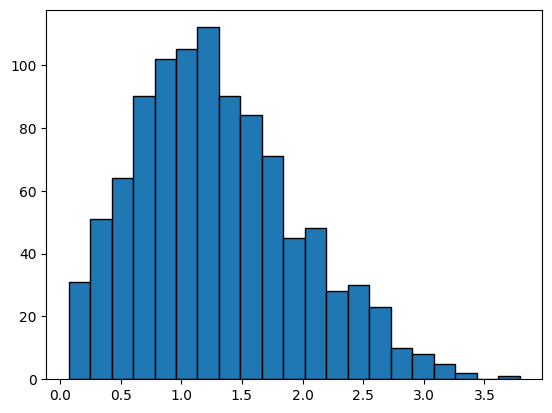

In [6]:
plt.hist(Br_results, bins='auto', edgecolor='black') 

# Run DFL Local SGD

In [7]:
def A_js(j, s, eta, alpha):
    if j == s:
        return 1.0
    ks = np.arange(j+1, s+1)
    return np.prod(1 - eta * (ks**-alpha))

In [8]:


def run_DFL(T, K, d, eta, alpha, tau, beta_true, beta_0,  sigma, weights, C, client_error):
    """
    Runs T iterations of decentralized gradient updates.

    Parameters:
      T         : int, total number of iterations.
      K         : int, number of clients/nodes.
      d         : int, dimensionality of the parameter vector.
      eta       : float, step-size constant.
      alpha     : float, exponent controlling step decay over iterations.
      tau       : int, frequency of communication (consensus) steps.
      beta_true : np.array, the true underlying d-dimensional parameter.
      sigma     : np.array, noise standard deviations for each client (length K).
      weights   : np.array, weights for each client (typically equal to 1/K).
      C         : np.array, K x K communication matrix.
      client_error: error vector in true beta for each client.

    Returns:
      theta_traj : list of np.arrays, each an (K x d) array of client parameters at each iteration.
      error_traj : list of floats, each the L2 norm error between the over-client mean parameter estimate and beta_true.
    """
    # Initialize: theta_traj holds the initial parameters and later updates.
    #Y_traj = [np.zeros(d)]
    #error_norm_traj = []
    #error_traj = []
    
    theta=np.zeros((K, d))
    Y = np.zeros(d)
    
    for t in range(T):
        # Use the most recent parameter matrix; .copy() is important to avoid unintended aliasing.
        #theta = theta_traj[-1].copy()

        # Local gradient descent update for each client
        for k in range(K):
            # Generate single sample for client k
            X_k = np.random.normal(loc=0.0, scale=1.0, size=(1, d))
            y_k = X_k @ (beta_true+client_error[k]) + sigma[k] * np.random.randn(1)
            
            # Compute the gradient at node k.
            # We reshape theta[k] and y_k to ensure proper dimensions.
            residual = X_k @ theta[k].reshape(-1, 1) - y_k.reshape(-1, 1)
            grad_k =  K * weights[k] * (X_k.T @ residual).flatten()
            
            # Update the parameter at client k
            theta[k] = theta[k] - eta * ((t+1) ** (-alpha)) * grad_k

        # Communication (consensus) step every tau iterations.
        if t % tau == 0:
            theta = C @ theta
            
        Y += np.mean(theta, axis=0)/T    
        
        #print(theta)
        
        
    # Compute error.
    error= (T**0.5)* Sigma_inv_sqrt@ (Y - beta_0)
    #print(error)
    error_norm = np.linalg.norm(error, ord=2)

    return Y, error_norm
    


In [9]:
## run DFL; B=total number of runs to -----------

from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def safe_run_simulation(T,K, sigma, weights, tau, C, client_error, seed):
    np.random.seed(seed)
    try:
        Y, error_norm = run_DFL(T, K, d, eta, alpha, tau, beta_true, beta_0, sigma, weights, C, client_error)
       # print(Y)
        return  error_norm
    except Exception as e:
        print(f"Error for seed = {seed}: {e}")
        return None


seeds = range(num_simulations)

T_list= [100, 200, 300, 400, 500]
tau_list = [10, 15, 20]

results_T=[]


for T in T_list:

    # Preallocate Q array and identity matrix
    Q = np.zeros((T, d, d))
    eye_d = np.eye(d)

    # Compute Q matrices efficiently
    for s in range(1, T + 1):
        eta_js_sum = sum(A_js(s, j, eta=eta, alpha=alpha) for j in range(s, T + 1))
        Q[s-1] = eta * (s ** -alpha) * eta_js_sum * eye_d
    #print(V_K)
    # Compute Sigma_T using einsum for efficient matrix multiplications
    Sigma_T = np.einsum('sij,jk,slk->il', Q, V_K, Q, optimize=True) / T

    # Eigen decomposition
    eigenvalues, Q_eig = np.linalg.eigh(Sigma_T)  # eigh for symmetric matrices

    # Compute inverse square root efficiently
    Lambda_inv_sqrt = 1.0 / np.sqrt(eigenvalues)
    Sigma_inv_sqrt = Q_eig * Lambda_inv_sqrt @ Q_eig.T
    print(Sigma_inv_sqrt)

    results = []     
    for tau in tqdm(tau_list, desc="tau", ncols=100, position=0):
    
        with tqdm_joblib(tqdm(desc="Running simulations", total=num_simulations, ncols=10)):
                results.append(Parallel(n_jobs=num_cores)(delayed(safe_run_simulation)(T,K, sigma, weights,tau, C, client_error, seed) for seed in seeds))
                #print(results)
    #print(results)    
    BS_DFL = []        
    for res in results:
        prob_DFL=np.array([np.mean(res <= x) for x in x_grid])
        #print(prob_DFL)
        BS_DFL.append(np.max(np.abs(prob_DFL-prob_Br)))
    results_T.append(np.array(BS_DFL))
    
    

/Users/sohambonnerjee/jupyter_env/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[[ 0.2439 -0.0045]
 [-0.0045  0.2458]]


tau:   0%|                                                                    | 0/3 [00:00<?, ?it/s]
Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

tau:  33%|████████████████████                                        | 1/3 [00:04<00:08,  4.33s/it]

Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

tau:  67%|████████████████████████████████████████                    | 2/3 [00:08<00:03,  3.96s/it]


Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
tau: 100%|████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.94s/it]


[[ 0.2337 -0.0043]
 [-0.0043  0.2356]]


tau:   0%|                                                                    | 0/3 [00:00<?, ?it/s]

Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

tau:  33%|████████████████████                                        | 1/3 [00:07<00:15,  7.91s/it]



Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
tau:  67%|████████████████████████████████████████                    | 2/3 [00:16<00:08,  8.48s/it]

Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

tau: 100%|████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.17s/it]


[[ 0.2322 -0.0042]
 [-0.0042  0.234 ]]


tau:   0%|                                                                    | 0/3 [00:00<?, ?it/s]




Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
tau:  33%|████████████████████                                        | 1/3 [00:14<00:28, 14.22s/it]

Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

tau:  67%|████████████████████████████████████████                    | 2/3 [00:27<00:13, 13.55s/it]





Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
tau: 100%|████████████████████████████████████████████████████████████| 3/3 [00:39<00:00, 13.19s/it]


[[ 0.2327 -0.0043]
 [-0.0043  0.2345]]


tau:   0%|                                                                    | 0/3 [00:00<?, ?it/s]

Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

tau:  33%|████████████████████                                        | 1/3 [00:16<00:32, 16.50s/it]






Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
tau:  67%|████████████████████████████████████████                    | 2/3 [00:31<00:15, 15.53s/it]

Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

tau: 100%|████████████████████████████████████████████████████████████| 3/3 [00:46<00:00, 15.38s/it]


[[ 0.2339 -0.0043]
 [-0.0043  0.2357]]


tau:   0%|                                                                    | 0/3 [00:00<?, ?it/s]







Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
tau:  33%|████████████████████                                        | 1/3 [00:18<00:36, 18.41s/it]

Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

tau:  67%|████████████████████████████████████████                    | 2/3 [00:37<00:18, 18.59s/it]








Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
tau: 100%|████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.27s/it]


In [10]:
results_T=[np.array(col) for col in zip(*results_T)]

In [11]:
results_T

[array([0.135, 0.082, 0.056, 0.04 , 0.028]),
 array([0.132, 0.076, 0.054, 0.038, 0.021]),
 array([0.129, 0.068, 0.044, 0.032, 0.022])]

In [12]:
run_DFL(T, K, d, eta, alpha, tau, beta_true, beta_0,  sigma, weights, C, client_error)

(array([ 1.3046, -2.4175]), np.float64(1.4285771188490002))

In [13]:
beta_0

array([ 1.2226, -2.679 ])

# Plotting

Running si
Running si
Running si
Running si
Running si
Running si
Running si
Running si


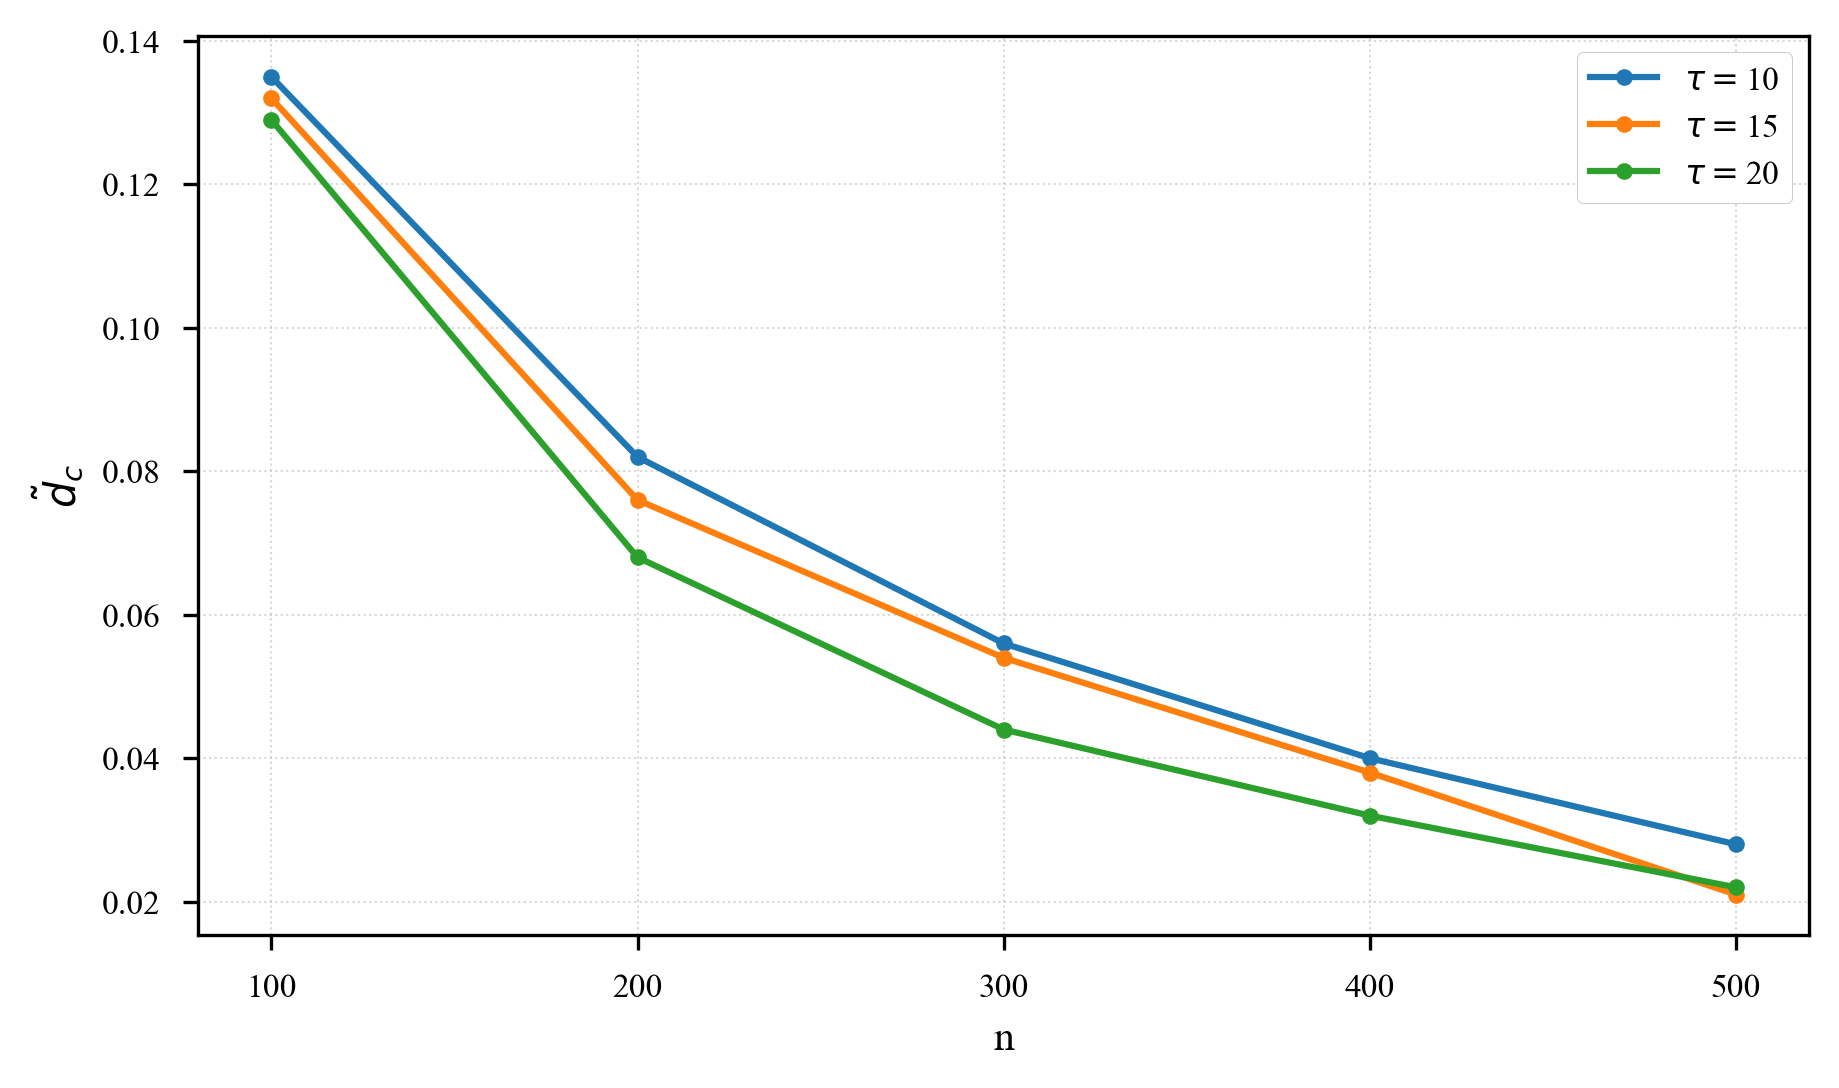

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# ======================
# NEURIPS STYLE SETTINGS
# ======================
plt.style.use('seaborn-v0_8-paper')  # Changed from 'seaborn-paper' to valid style
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 5
rcParams['axes.labelsize'] = 5
rcParams['axes.titlesize'] = 7
rcParams['legend.fontsize'] = 5
rcParams['xtick.labelsize'] = 3
rcParams['ytick.labelsize'] = 3
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['axes.grid'] = True
rcParams['grid.alpha'] = 0.0
rcParams['lines.linewidth'] = 2


plt.figure(figsize=(6, 3.5))  # NeurIPS prefers smaller figures

# Create plot
for i, T_data in enumerate(results_T):
    plt.plot(T_list, T_data, label=r'$\tau = $' f'{tau_list[i]}', 
             marker='o', markersize=4, linewidth=1.5)

# Customize the plot
plt.xlabel('n', fontsize=10)
plt.ylabel(r'$\tilde{d}_c$', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5, linewidth=0.5)
plt.legend(fontsize=8, framealpha=1, frameon=True)

# Use tight layout and adjust ticks
plt.xticks(T_list, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.5)

 #Save with appropriate DPI for publications
plt.savefig(f'berry-esseen_client_error_variance_{varscale}_tau_varying, tau={tau_list},N={T_list}.png', 
            bbox_inches='tight', 
             pad_inches=0.05,
            dpi=300)